11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training basic autoencoder …
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3898 - val_loss: 0.1868
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1773 - val_loss: 0.1521
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1478 - val_loss: 0.1327
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1314 - val_loss: 0.1212
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1207 - val_loss: 0.1132
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1130 - val_loss: 0.1073
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1076 - val_loss: 0.1032
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1033 - val_loss: 0.0998
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1004 - val_loss: 0.0974
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0983 - val_loss: 0.0959
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - los

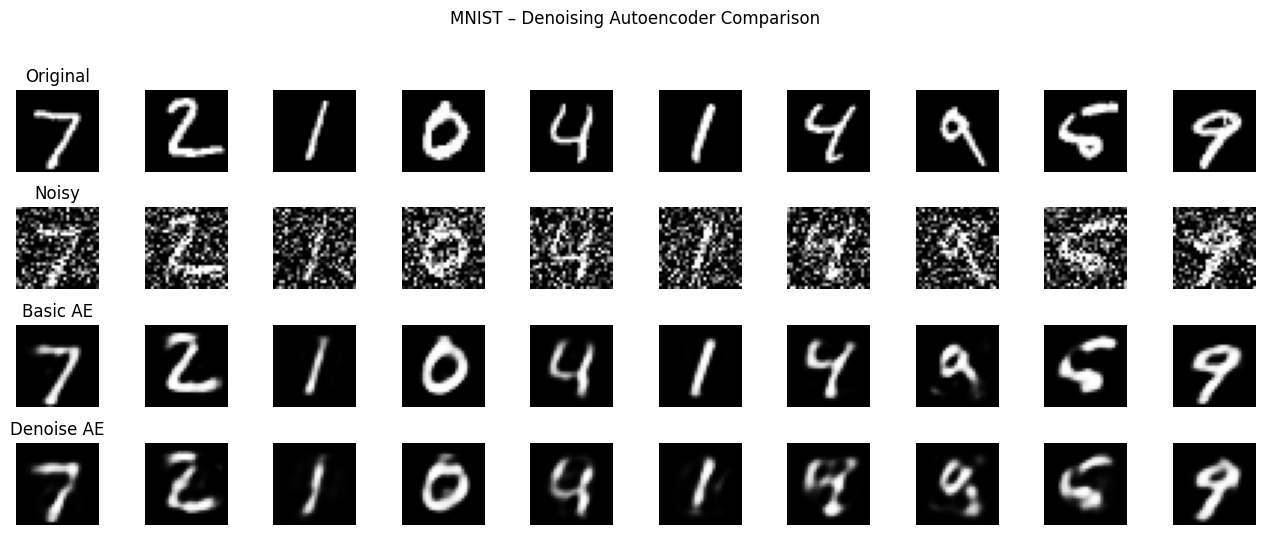


Final Validation BCE:
Basic AE      : 0.0923
Denoising AE  : 0.1244


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# =============================
# MNIST Denoising Autoencoder
# =============================
# 1. Load & normalise data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Helper: build a simple dense autoencoder

def build_autoencoder(latent_dim: int = 32):
    inputs = layers.Input(shape=(784,))
    encoded = layers.Dense(latent_dim, activation="relu")(inputs)
    decoded = layers.Dense(784, activation="sigmoid")(encoded)
    ae = models.Model(inputs, decoded)
    ae.compile(optimizer="adam", loss="binary_crossentropy")
    return ae

# 2. Create noisy inputs (Gaussian, mean=0, std=0.5)
noise_factor = 0.5
rng = np.random.default_rng(seed=42)

def add_noise(x):
    noisy = x + noise_factor * rng.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noisy, 0.0, 1.0)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# 3. Train basic & denoising autoencoders (latent dim =32)
basic_ae = build_autoencoder(32)
denoise_ae = build_autoencoder(32)

print("Training basic autoencoder …")
basic_hist = basic_ae.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=1,
)

print("\nTraining denoising autoencoder …")
denoise_hist = denoise_ae.fit(
    x_train_noisy,
    x_train,  # targets are clean images
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    verbose=1,
)

# 4. Visualise: original | noisy | recon (basic) | recon (denoise)
num = 10
plt.figure(figsize=(num * 1.3, 4 * 1.3))
for i in range(num):
    # Original
    ax = plt.subplot(4, num, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")
    # Noisy
    ax = plt.subplot(4, num, num + i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Noisy")
    # Basic recon
    basic_recon = basic_ae.predict(x_test[i : i + 1], verbose=0)
    ax = plt.subplot(4, num, 2 * num + i + 1)
    plt.imshow(basic_recon.reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Basic AE")
    # Denoised recon
    den_recon = denoise_ae.predict(x_test_noisy[i : i + 1], verbose=0)
    ax = plt.subplot(4, num, 3 * num + i + 1)
    plt.imshow(den_recon.reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Denoise AE")

plt.suptitle("MNIST – Denoising Autoencoder Comparison", y=1.02)
plt.tight_layout()
plt.show()

# 5. Print final validation losses
print("\nFinal Validation BCE:")
print(f"Basic AE      : {basic_hist.history['val_loss'][-1]:.4f}")
print(f"Denoising AE  : {denoise_hist.history['val_loss'][-1]:.4f}")

# ===== Note on usefulness =====
# Denoising autoencoders excel in scenarios like low‑dose CT scans where you want to recover clear medical images while keeping patient radiation minimal.
